In [8]:
from hossam import load_data

from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from pandas import DataFrame
import seaborn as sb
import numpy as np
from math import sqrt
from scipy.stats import t,ttest_1samp, normaltest

In [9]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [10]:
origin = load_data('bread')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 데이터 크기 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/bread.xlsx
[desc] 매일 아침 동네 빵집에서 식빵을 구입해 무게를 기록한 데이터
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (25, 1)
열 개수: 1
행 개수: 25

===== 데이터 크기 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   무게      25 non-null     int64
dtypes: int64(1)
memory usage: 332.0 bytes
None


,무게
0,482
1,479
2,485
3,474
4,479


# 가설검정의 가정 확인


1.정규성
KDE를 통한 평균 확인

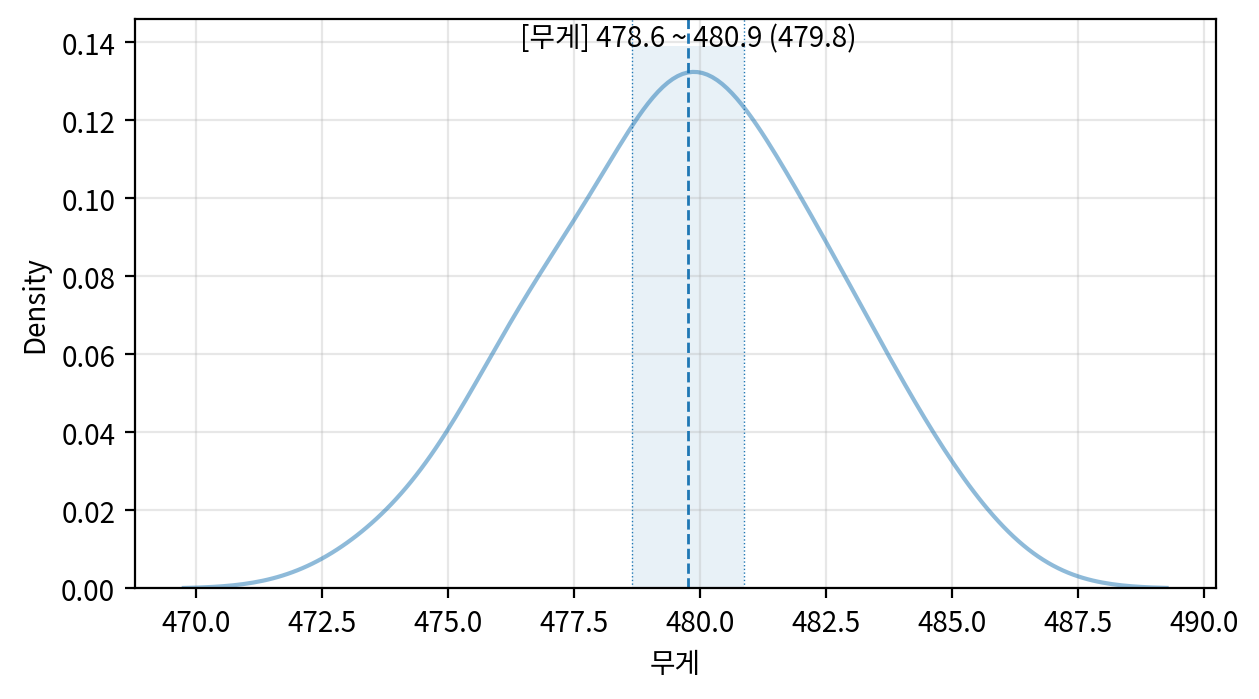

In [11]:
data = origin[['무게']]

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c])-1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ax.text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f (%0.1f)" % (c, cmin, cmax, sp_mean), horizontalalignment="center")


ax.grid(True, alpha=0.3)









plt.tight_layout()
plt.show()
plt.close()

표본평균이 신뢰구간 범위에 속해 있으므로, 표본(내가 구입한 빵)평균이 모집단(빵집에서 판매하는 모든 빵) 평균과 큰 차이가 없음을 의미

그러므로 내가 구입한 빵 만으로 이 빵집의 모든 빵에 대한 평균 무게를 추측해도 된다는 것을 의미.

In [12]:
data = origin[['무게']]

equal_var_fields=[]
normal_dist = True
report = []

for c in data.columns:
    s, p =normaltest(data[c])

    normalize = p>0.05
    report.append({
        "field":c,
        "statistic":s,
        "p-value" : p,
        "result":normalize
    })
    normal_dist = normal_dist and normalize
#변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"
        #정규성을 충족할 경우의 검정방법
        s,p = bartlett(*data.values.T)
        #모든 컬럼의 데이터를 한번에 전달

    else:
        n = "Levene"    #정규성을 충족하지 않을 경우의 검정방법

        s, p = levene(*data.values.T, center='median')  # 모든 컬럼의 데이터를 한번에 전달

    report.append({
        "field":n,
        "statistic":s,
        "p-value" : p,
        "result":p>0.05
    })

report_df = DataFrame(report).set_index('field')
report_df






,statistic,p-value,result
field,,,
무게,0.083295,0.959208,True


# 단일표본 T-Test

In [14]:
s, p = ttest_1samp(origin['무게'], 500)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s,p, "대립"if p <=0.05 else "귀무")                                                                                                                                                                               

'statistic: -37.524, p-value: 0.000, 대립가설 채택'

In [16]:
s, p = ttest_1samp(origin['무게'], 500,alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <=0.05 else "귀무")

'statistic: -37.524, p-value: 0.000, 대립가설 채택'

In [18]:
s, p = ttest_1samp(origin['무게'], 500, alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s,p, "대립"if p <=0.05 else "귀무")

'statistic: -37.524, p-value: 1.000, 귀무가설 채택'